In [1]:
!pip install numpy scipy matplotlib networkx #persim 
!pip install gudhi 

ERROR: Invalid requirement: '#persim'

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python3.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python3.exe -m pip install --upgrade pip


- import libraries 






In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx 
from persim import plot_diagrams 
import gudhi as gd 
from typing import Tuple, List, Callable 



In [12]:
class TopologicalDivergence:
    def __init__(self):
        self.graphs={}
        self.functions = {} 
    def create_graphs(self, n_vertices:int):
        """
        Create a graph from the scalar function, for testing purposes
        """
        # Graph 1: Simple cycle graph 
        G1 = nx.cycle_graph(n_vertices)
        pos1 = nx.circular_layout(G1)

        # Graph 2: Random geometric graph 
        G2 = nx.random_geometric_graph(n_vertices,0.4,seed=42)
        pos2 = {i: (pos[0],pos[1]) for i,pos in enumerate(nx.get_node_attributes(G2, 'pos').values())}
        self.graphs['cycle'] = (G1,pos1)
        self.graphs["random"] = (G2,pos2)
    def create_functions(self, n_vertices:int):
        """
        Create scalar functions for testing purposes 
        """
        x = np.linspace(0,1,n_vertices)     
        # Function 1: Constant function 
        f1 = np.ones_like(x)
        # Function 2: Linear function 
        f2 = x 
        # Function 3: Quadratic function 
        f3 = x**2
        # Function 4: Gaussian function 
        f4 = np.exp(-(x-0.5)**2/0.1)
        # Function 5: Step function 
        f5 = np.where(x<0.5,0,1)
        self.functions['constant'] = f1
        self.functions['linear'] = f2
        self.functions['quadratic'] = f3
        self.functions['gaussian'] = f4
        self.functions['step'] = f5

    def build_F_matrix(self, graph:nx.Graph, f:np.ndarray)->np.ndarray:
        """
        Build the F matrix for a given scalar function 
        """
        n_vertices = len(graph.nodes())
        F = np.full((n_vertices,n_vertices), np.inf)

        # Set the diagonal elements as the array function values
        np.fill_diagonal(F,f)

        # Set the edge elements 
        for i,j in graph.edges():
            F[i,j] = max(f[i],f[j])
            F[j,i] = max(f[i],f[j])
        return F 

    def build_F_plus_matrix(self, graph:nx.graph, f:np.ndarray) ->np.ndarray:
        """
        Build the F+ matrix for a given scalar function, which is F with lower diagonal as 0
        """
        n_vertices = len(graph.nodes())
        F = np.full((n_vertices,n_vertices), np.inf)

        # Set the diagonal elements as the array function values
        np.fill_diagonal(F,f)

        # Set the edge elements 
        for i,j in graph.edges():
            if i>j:
                F[j,i] = max(f[i],f[j])
        return F 

    def build_min_FG_matrix(self, graph:nx.Graph, f:np.ndarray, g:np.ndarray)->np.ndarray:
        """
        Build the min_FG matrix for a given scalar function 
        """
        n_vertices = len(graph.nodes())
        min_FG = np.full((n_vertices,n_vertices), np.inf)

        # # Set the diagonal elements as the array function values
        # for i in range(n_vertices):
        #     min_FG[i,i] = min(f[i],g[i])
        np.fill_diagonal(min_FG, np.minimum(f, g))

        # Set the edge elements 
        for i,j in graph.edges():
            min_FG[i,j] = np.maximum(np.minimum(f[i],g[i]),np.minimum(f[j],g[j]))
            min_FG[j,i] = np.maximum(np.minimum(f[i],g[i]),np.minimum(f[j],g[j]))
        return min_FG 
    def build_min_value_fg(self, f:np.ndarray, g:np.ndarray)->np.float32:
        return min(np.min(f),np.min(g))

    def build_block_matrix(self, F:np.ndarray, G:np.ndarray, min_FG: np.ndarray, min_value_fg:np.float32)->np.ndarray:
        """
        Build the (2n+1)*(2n+1) block matrix 
        """ 
        n_vertices = F.shape[0]
        n = n_vertices
        # Create a large block matrix 
        m = np.zeros((2*n_vertices+1, 2*n_vertices+1))
        m.fill(np.inf)
        # Fill the block 
        m[:n,:n] = min_FG 
        m[n:2*n,n:2*n] = F
        m[n:2*n,:n] = G 
        m[:n, n:2*n] = G.T
        m[-1,n:2*n] = np.diag(F)
        m[n:2*n,-1] = np.diag(F)
        m[-1,-1] = min_value_fg
        return m
    def compute_persistence_barcode(self, distance_matrix: np.ndarray, k:int =1) -> List[Tuple[float,float]]:
        """
        Compute the h-th persistent barcode using Gudhi
        """
        # Create a simplex tree from the distance matrix 
        rips_complex = gd.RipsComplex(distance_matrix=distance_matrix)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=k+1)

        # Compute persistence 
        persistence = simplex_tree.persistence() 

        # Filter for k-dimensional homology 
        k_persistence = [pers for pers in persistence if pers[0]==k]
        return k_persistence 
        
        
    def f_cross_barcode_k(self, graph:nx.Graph, f:np.ndarray, g:np.ndarray, k:int =1):
        """
        Algorithm 1: F-cross barcode k
        """
        n = len(graph.nodes())

        # Step 1: Create F matrix 
        min_FG = self.build_min_FG_matrix(graph, f,g)
        F = self.build_F_matrix(graph, f)
        F_plus = self.build_F_plus_matrix(graph,f)
        min_value_fg = self.build_min_value_fg(f,g)
        block_matrix = self.build_block_matrix(F,F_plus, min_FG,min_value_fg)
        persistence = self.compute_persistence_barcode(block_matrix, k)
        return persistence 
    def visualize_graph_function(self, graph: nx.Graph, pos: dict, f: np.ndarray, title: str):
        """Visualize graph with function values on vertices - FIXED VERSION"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Normalize function values for coloring
        if np.max(f) != np.min(f):
            normalized_f = (f - np.min(f)) / (np.max(f) - np.min(f))
        else:
            normalized_f = np.ones_like(f)
        
        # Draw graph with explicit axes
        nodes = nx.draw_networkx_nodes(graph, pos, 
                                     node_color=normalized_f,
                                     node_size=500,
                                     cmap=plt.cm.viridis,
                                     ax=ax)
        
        nx.draw_networkx_edges(graph, pos, 
                             edge_color='gray',
                             ax=ax)
        
        nx.draw_networkx_labels(graph, pos, 
                              font_weight='bold',
                              ax=ax)
        
        # Add colorbar with explicit reference to the figure and axes
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                 norm=plt.Normalize(vmin=np.min(f), vmax=np.max(f)))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Function value')
        
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
    
    def visualize_persistence_diagram(self, persistence: List[Tuple[float, float]], title: str):
        """Visualize persistence diagram"""
        if not persistence:
            print(f"No persistence pairs found for {title}")
            return
            
        # Extract birth and death times
        birth_times = [pers[1][0] for pers in persistence]
        death_times = [pers[1][1] for pers in persistence]
        
        plt.figure(figsize=(8, 6))
        plt.scatter(birth_times, death_times, color='red', s=50)
        
        # Plot diagonal line
        max_val = max(max(birth_times), max(death_times)) if death_times else max(birth_times)
        plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
        
        plt.xlabel('Birth Time')
        plt.ylabel('Death Time')
        plt.title(f'Persistence Diagram: {title}')
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    def print_matrix_info(self, matrix: np.ndarray, name: str):
        """Helper function to print matrix information"""
        print(f"{name} - Shape: {matrix.shape}, Min: {np.min(matrix[matrix != np.inf]):.3f}, "
              f"Max: {np.max(matrix[matrix != np.inf]):.3f}, "
              f"Non-inf elements: {np.sum(matrix != np.inf)}")



        
        



Analyzing Graph: CYCLE


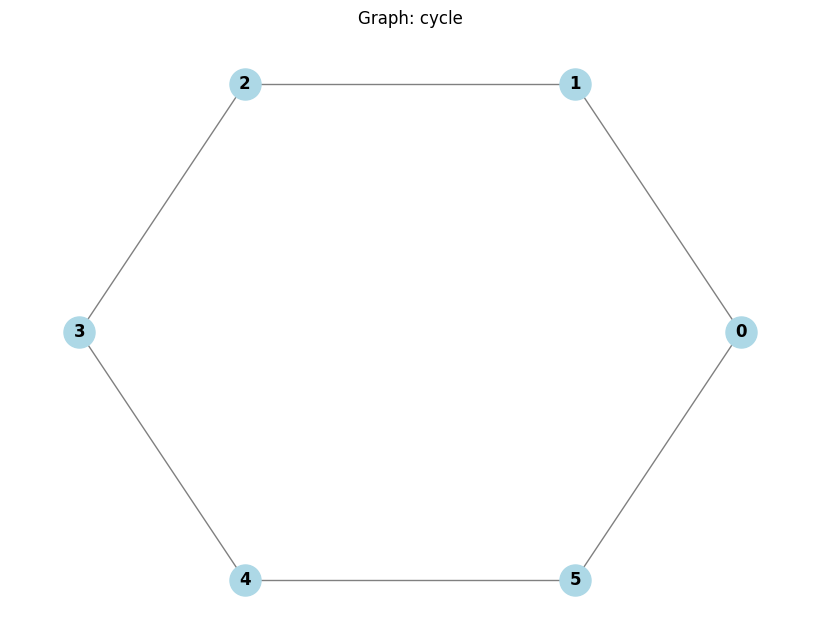


Comparing constant vs constant:


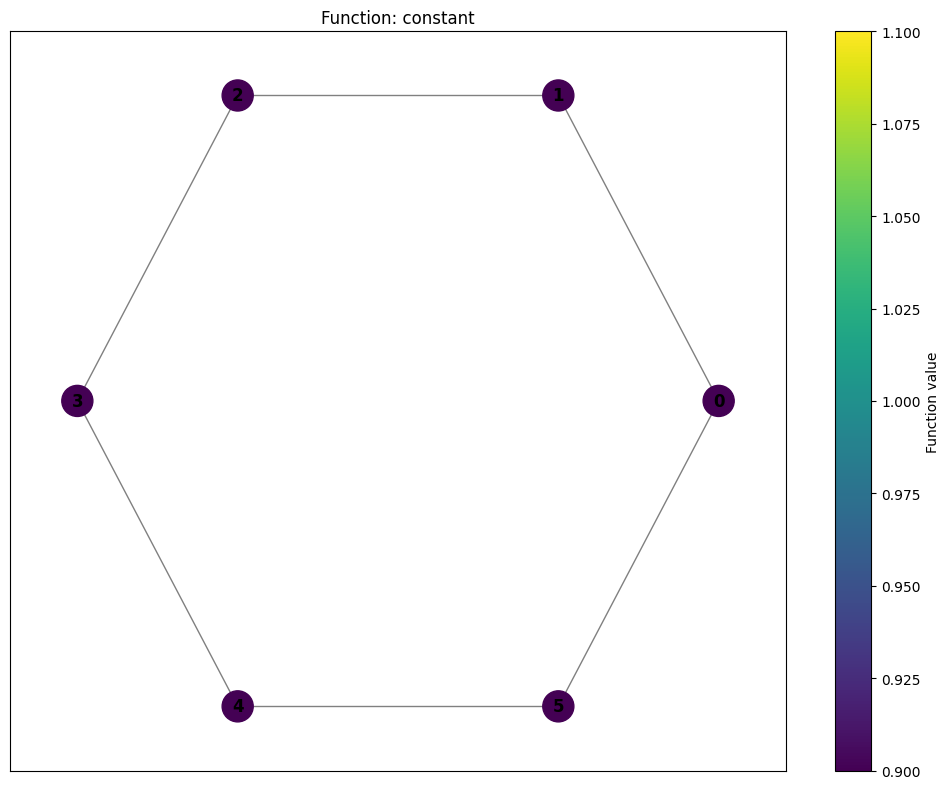

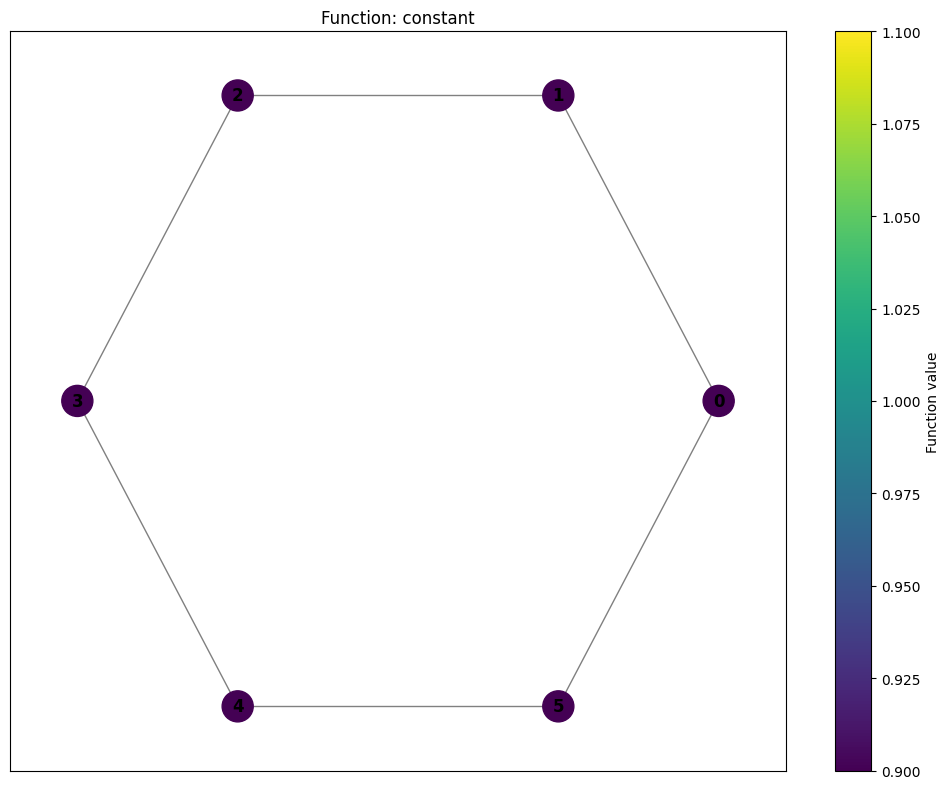

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf


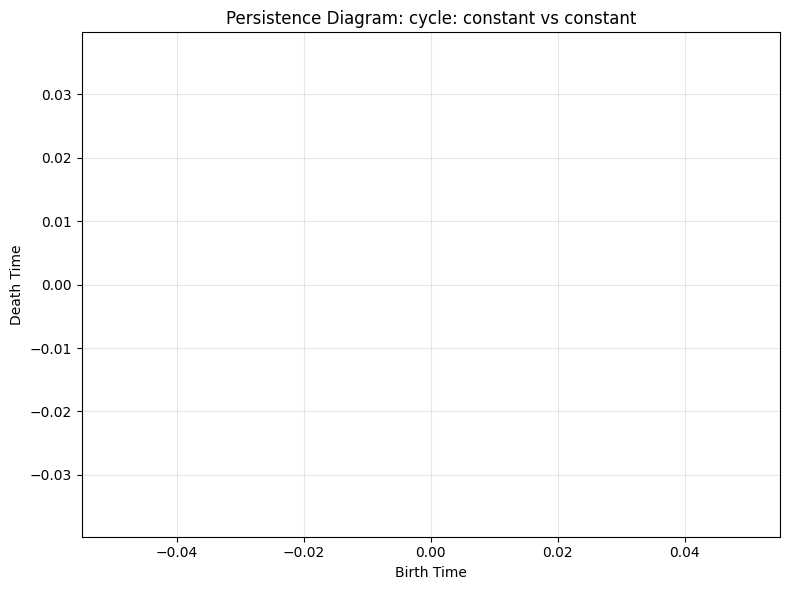


Comparing linear vs linear:


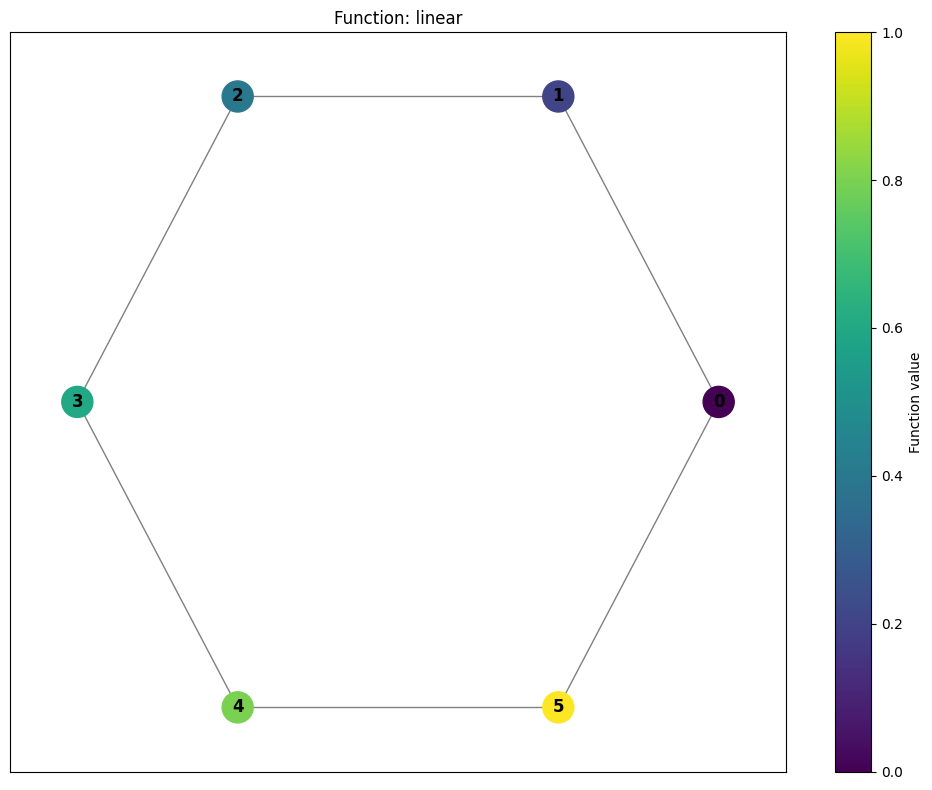

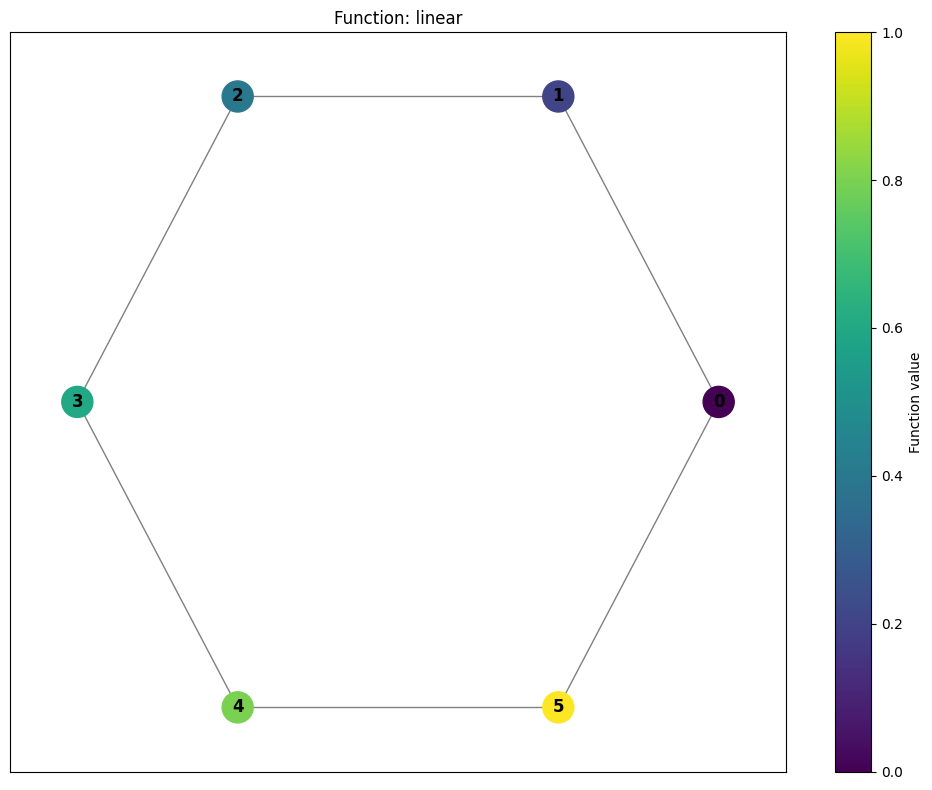

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 0.200, Death: inf
  Birth: 0.400, Death: inf
  Birth: 0.600, Death: inf
  Birth: 0.800, Death: inf
  Birth: 1.000, Death: inf


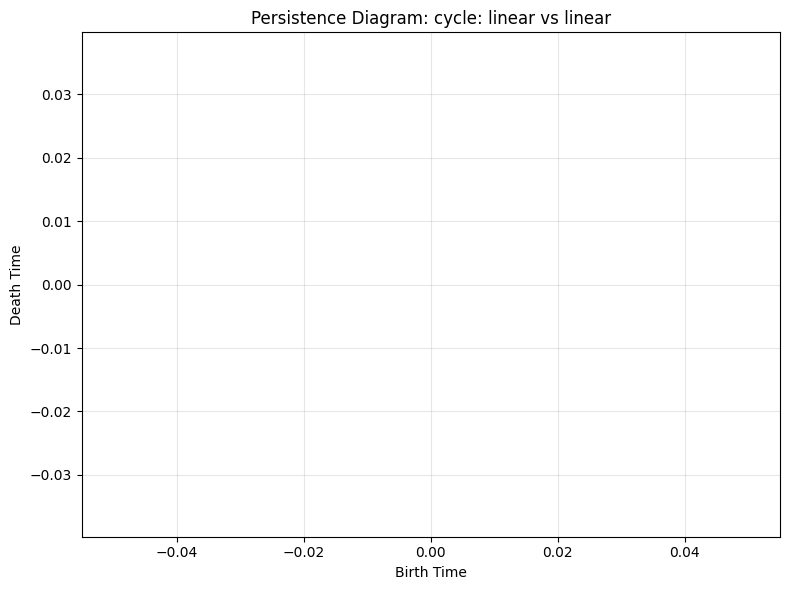


Comparing quadratic vs quadratic:


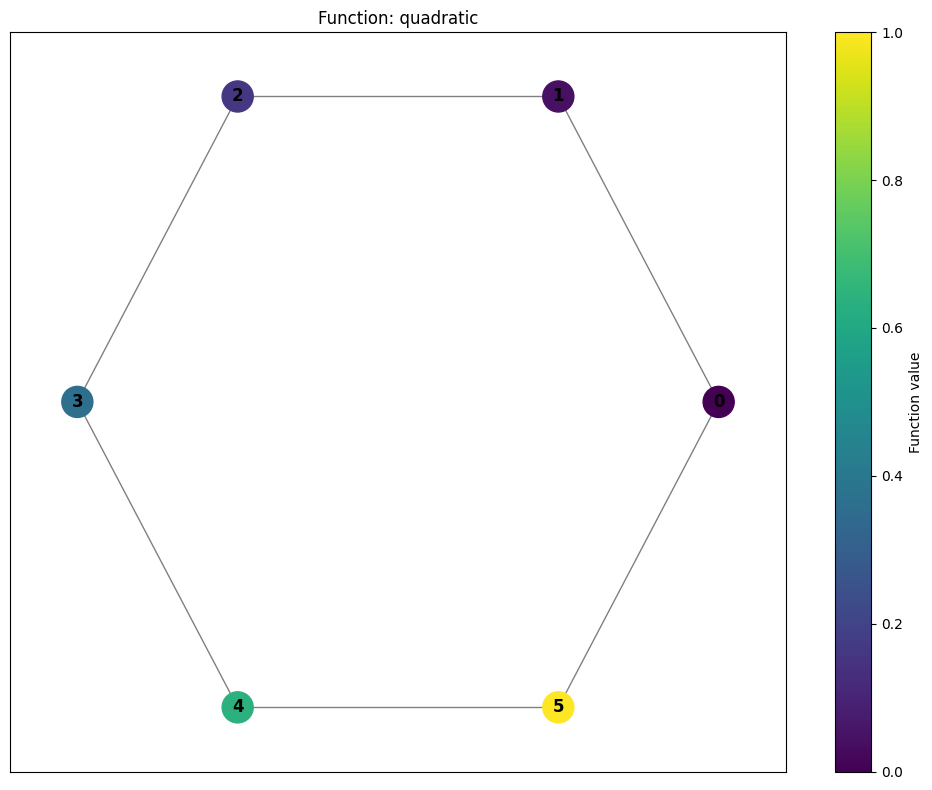

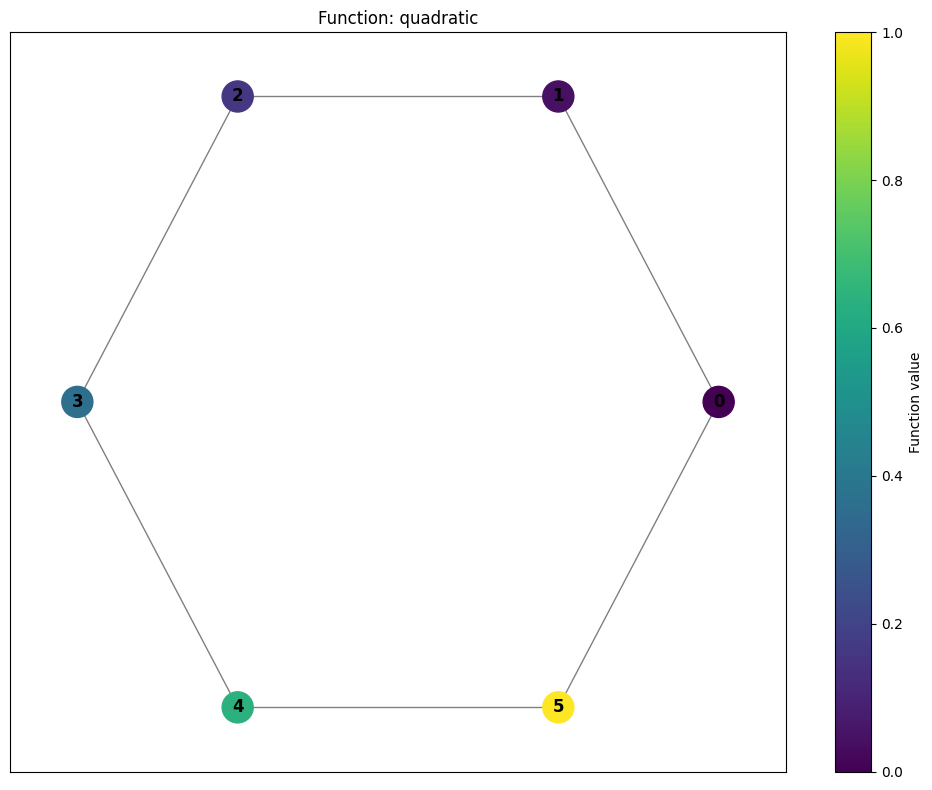

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 0.040, Death: inf
  Birth: 0.160, Death: inf
  Birth: 0.360, Death: inf
  Birth: 0.640, Death: inf
  Birth: 1.000, Death: inf


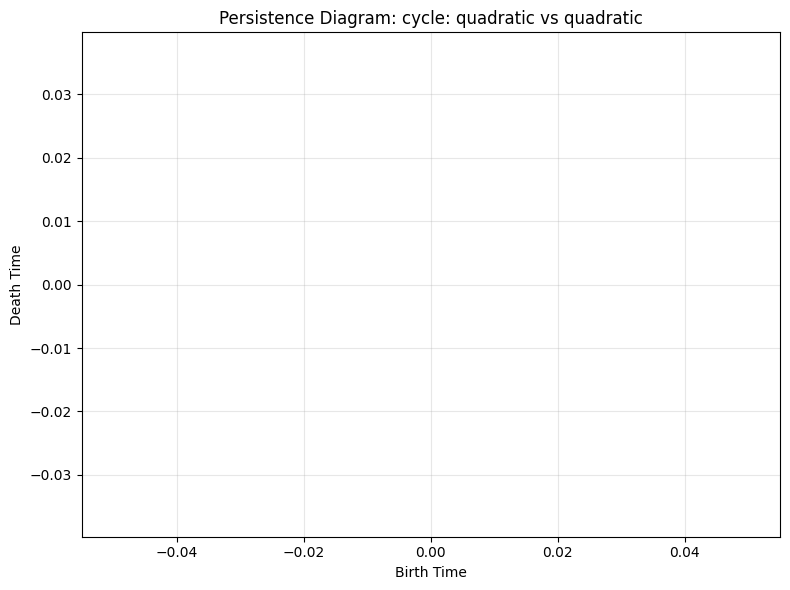


Comparing gaussian vs gaussian:


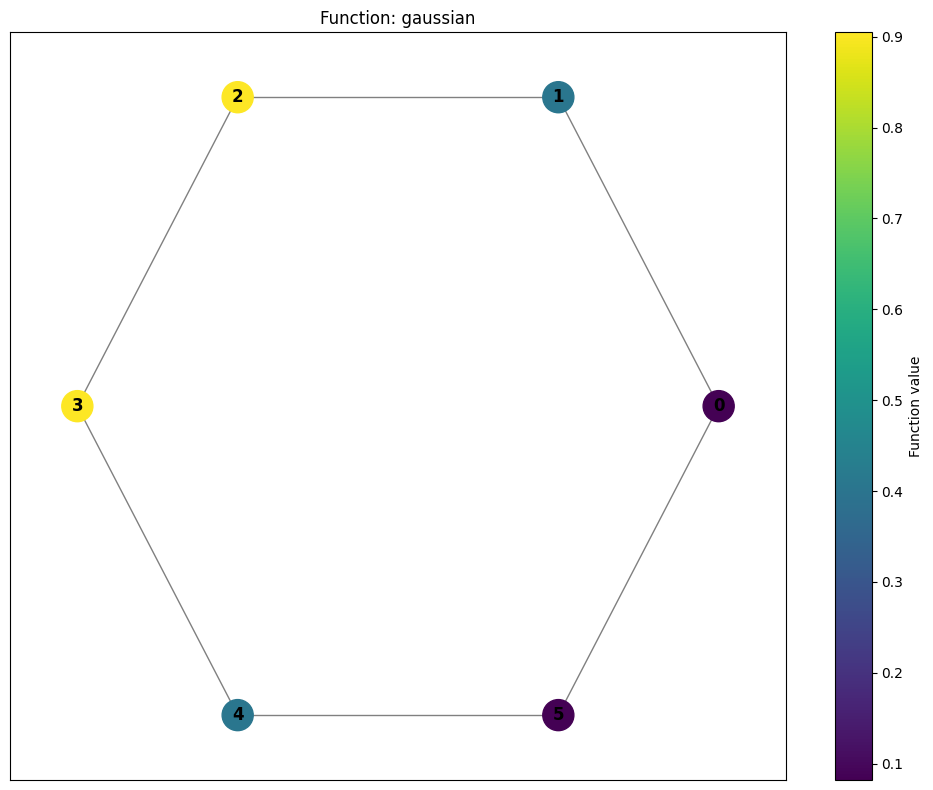

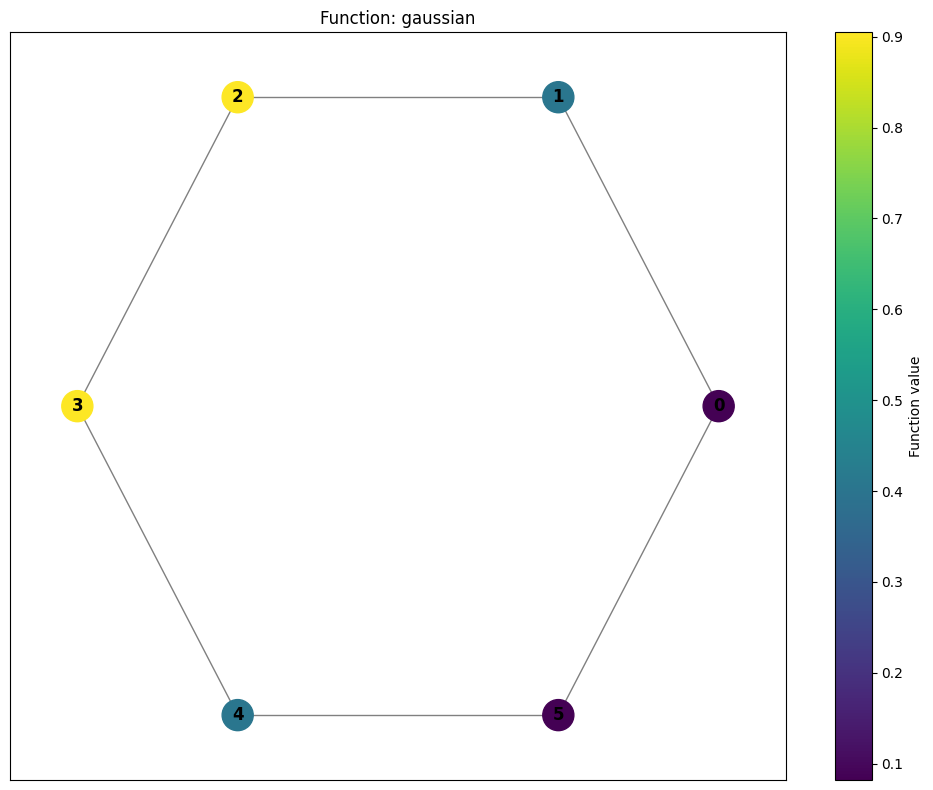

Persistence pairs (dimension 1):
  Birth: 0.905, Death: inf
  Birth: 0.407, Death: inf
  Birth: 0.905, Death: inf
  Birth: 0.905, Death: inf
  Birth: 0.407, Death: inf
  Birth: 0.082, Death: inf


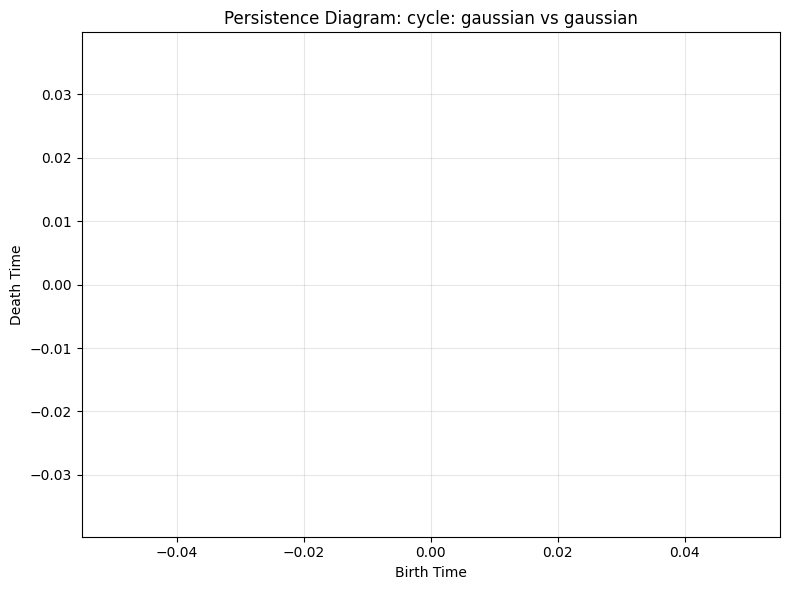


Comparing step vs step:


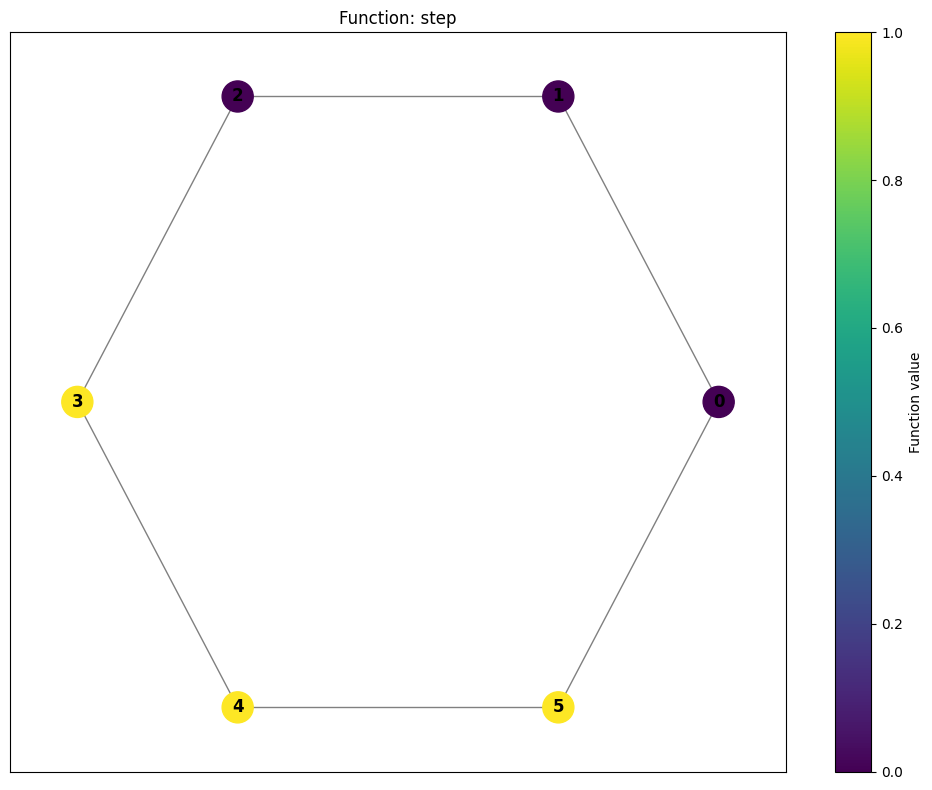

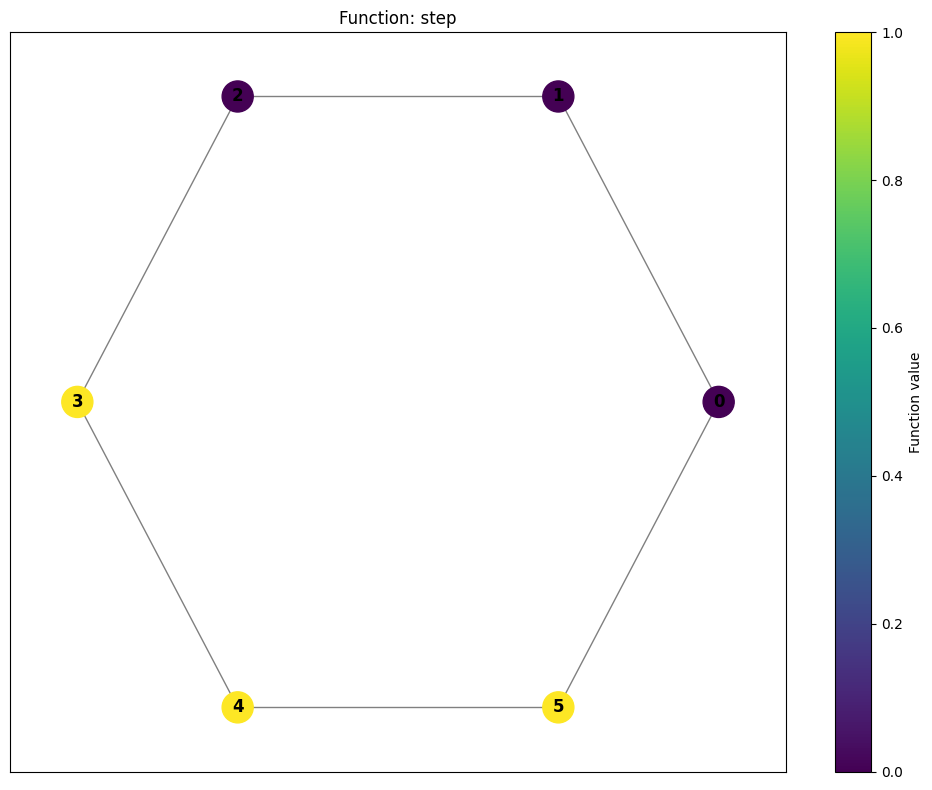

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 0.000, Death: inf
  Birth: 0.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf


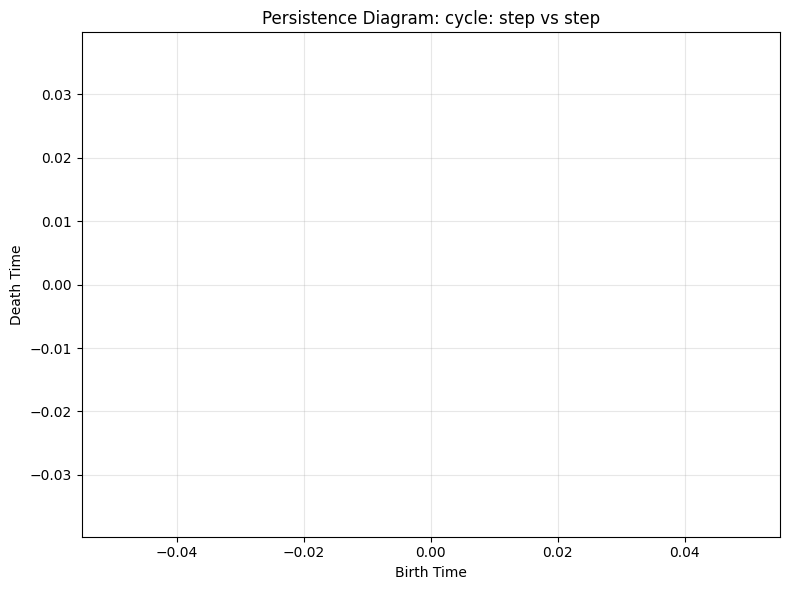


Analyzing Graph: RANDOM


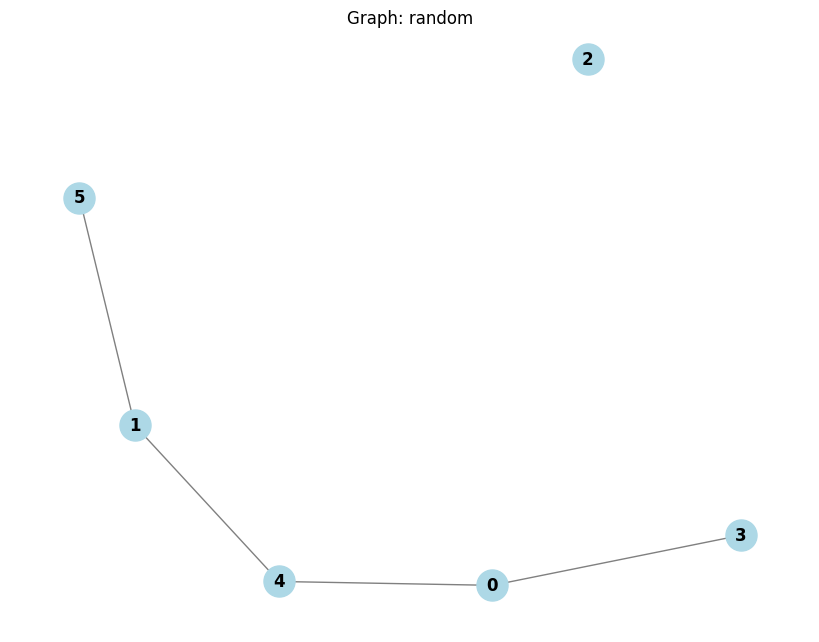


Comparing constant vs constant:


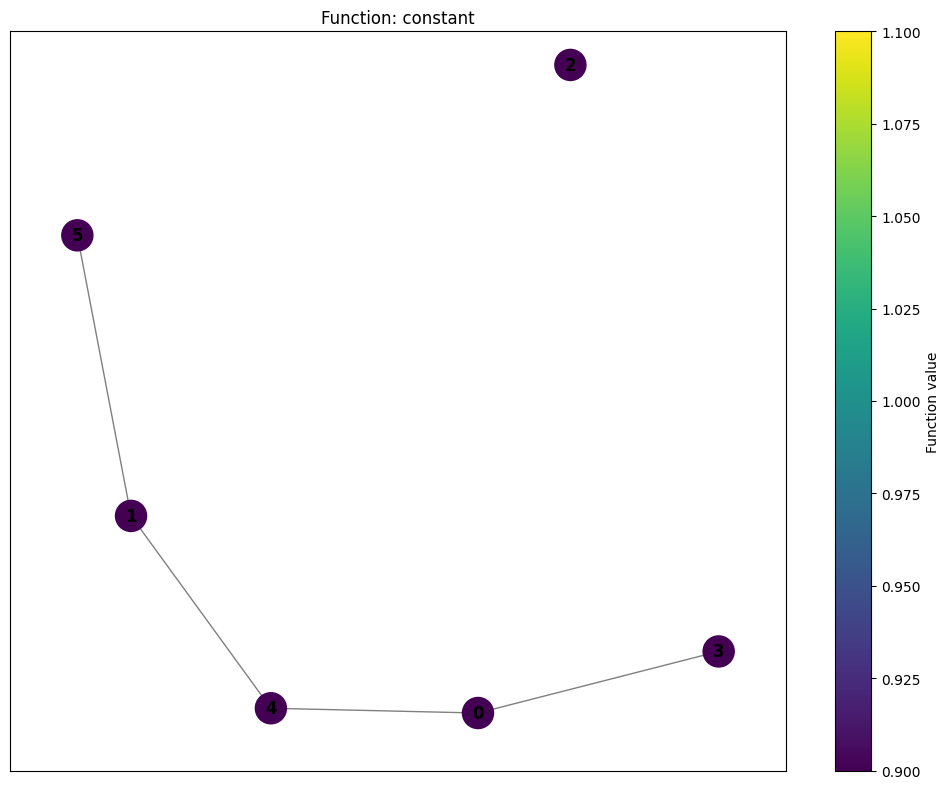

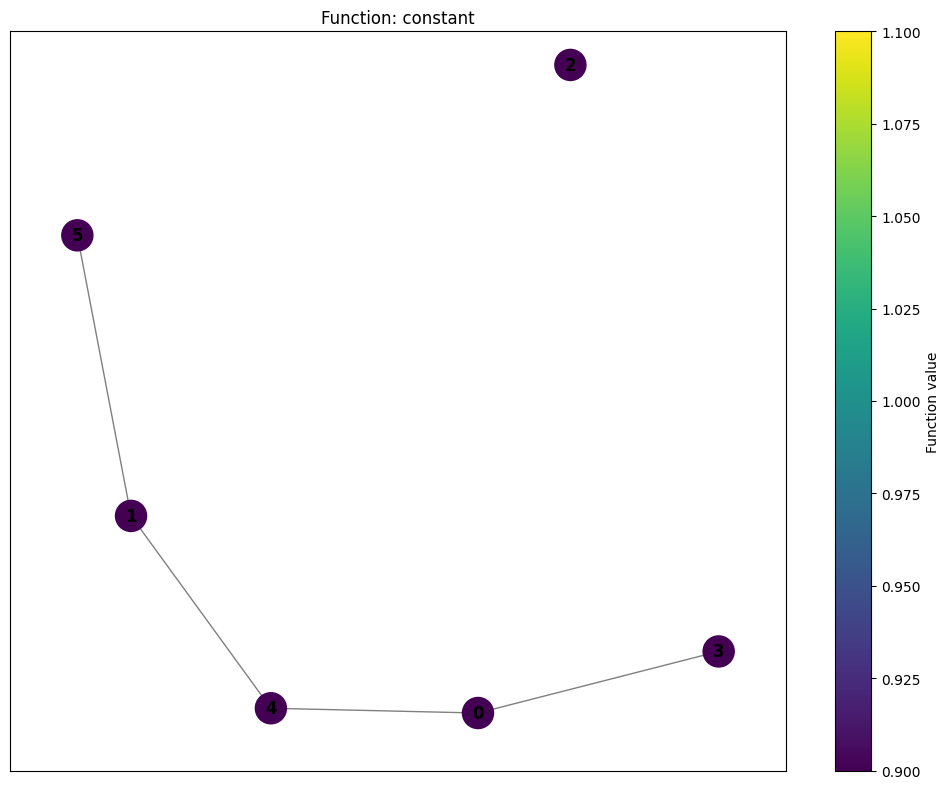

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf


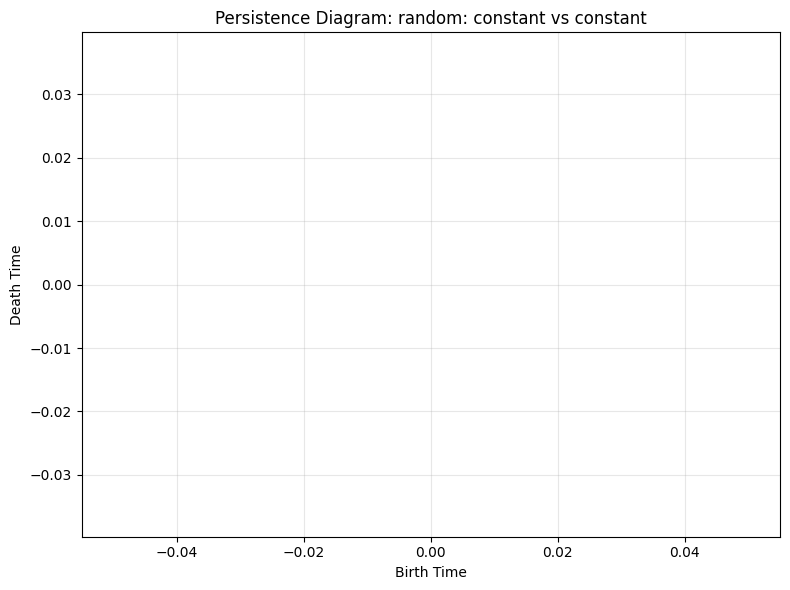


Comparing linear vs linear:


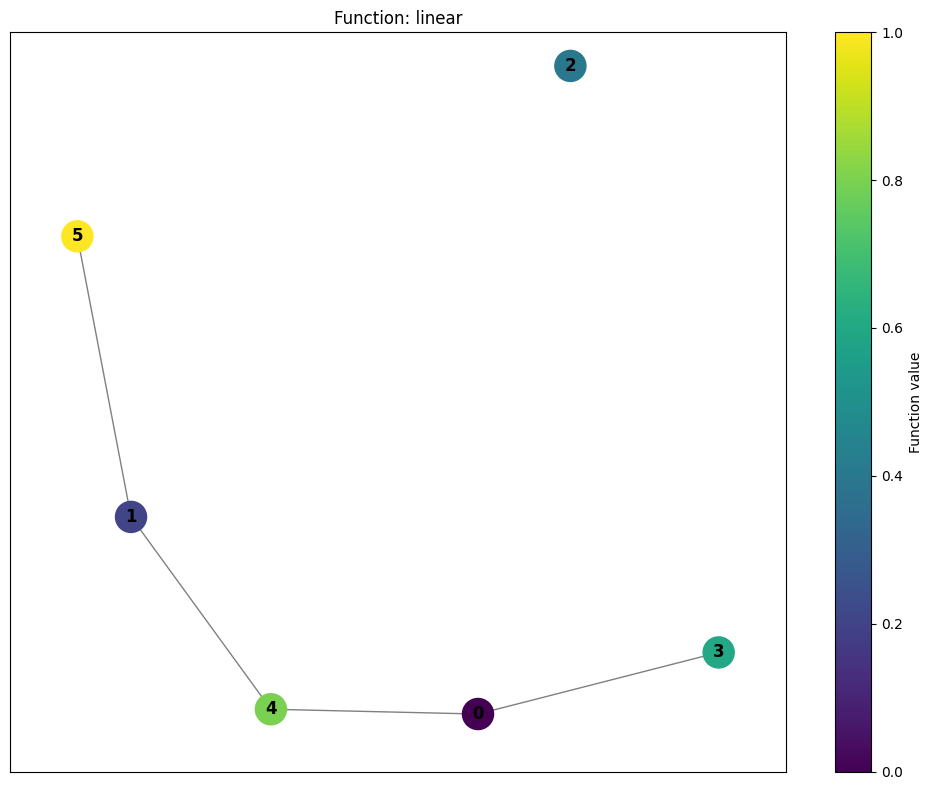

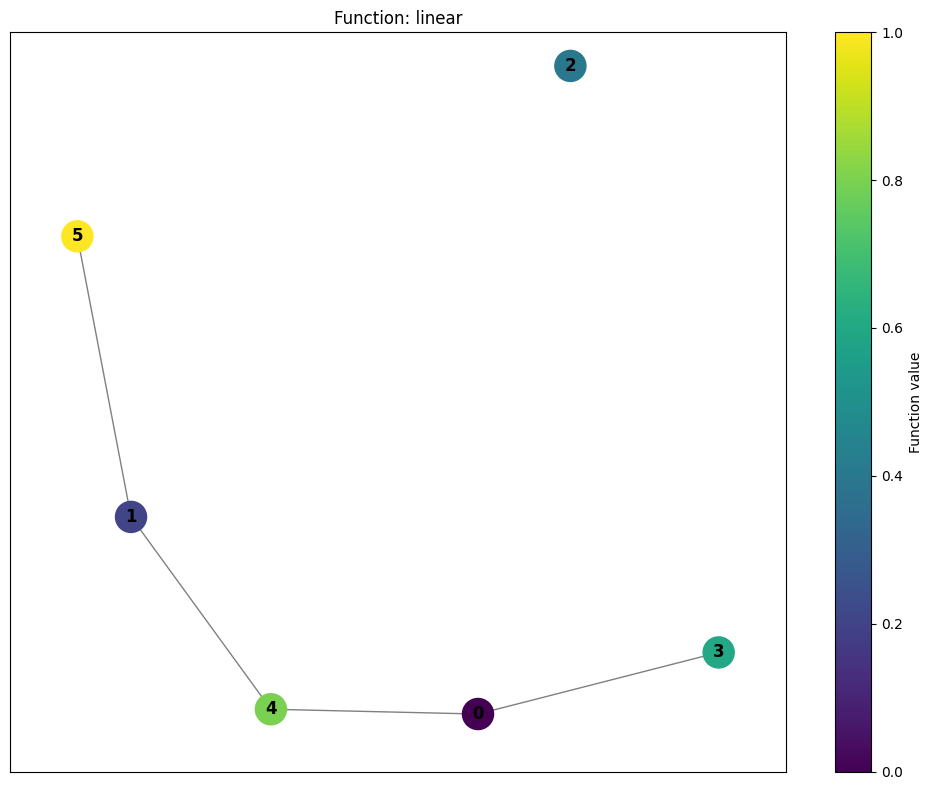

Persistence pairs (dimension 1):
  Birth: 0.600, Death: inf
  Birth: 0.800, Death: inf
  Birth: 0.800, Death: inf
  Birth: 1.000, Death: inf


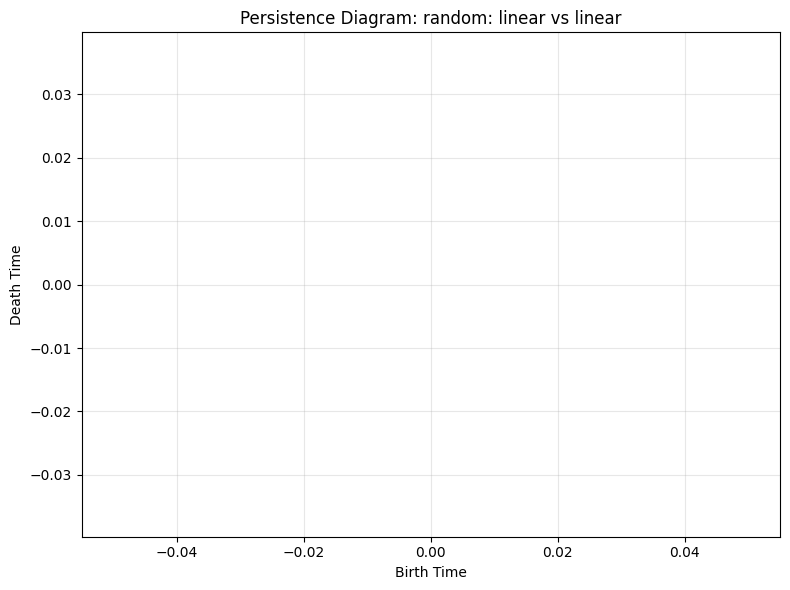


Comparing quadratic vs quadratic:


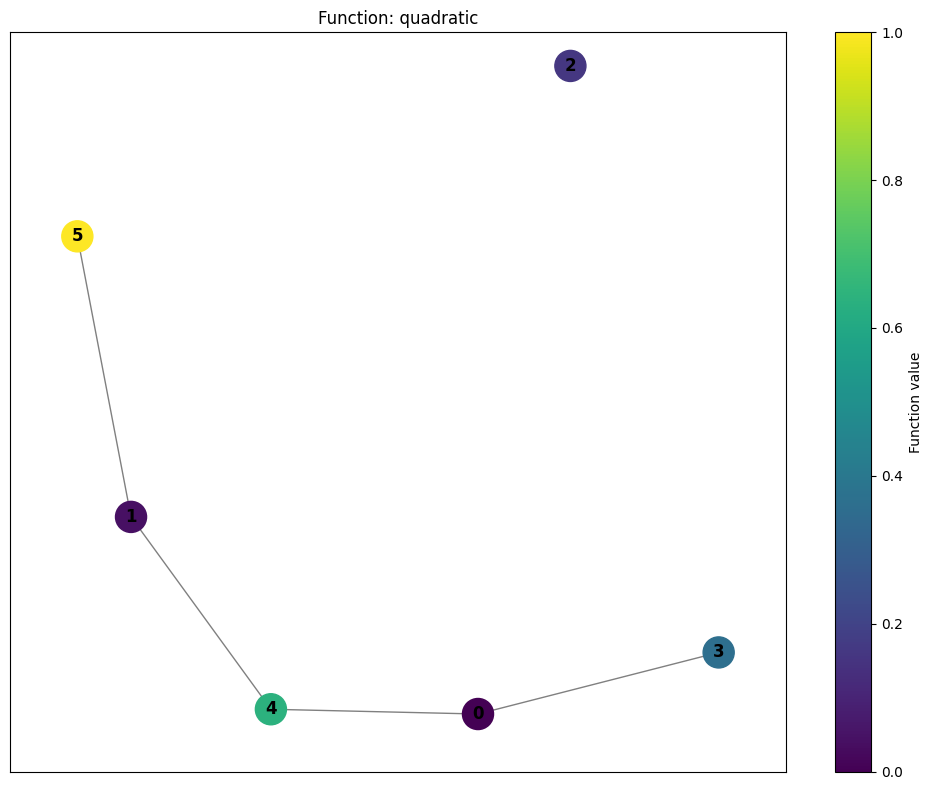

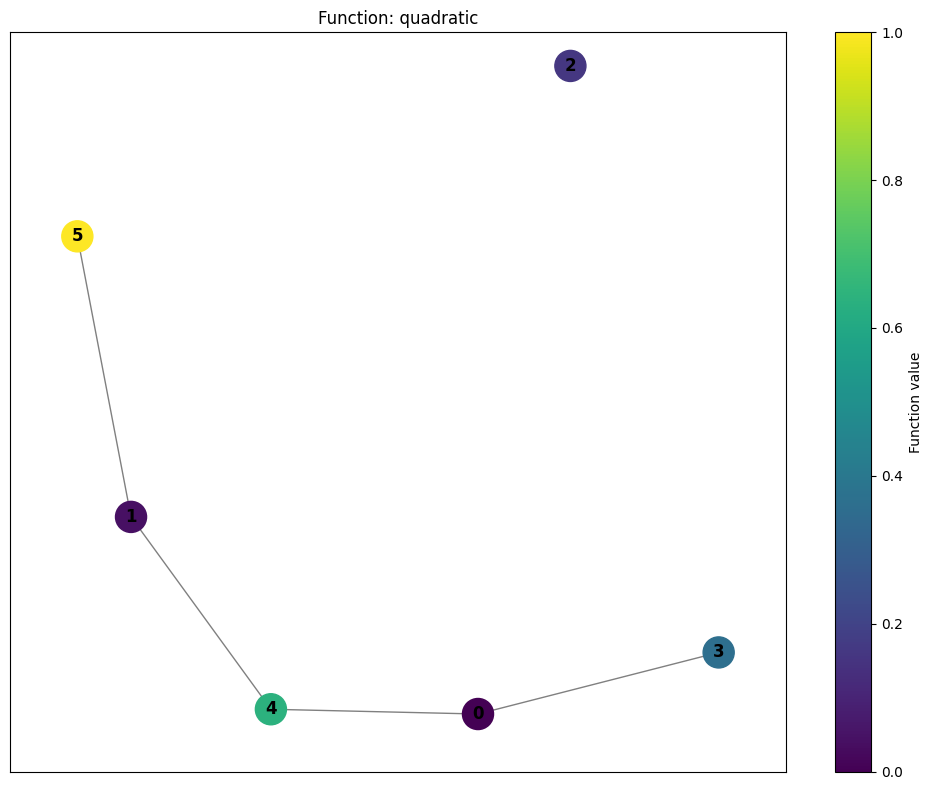

Persistence pairs (dimension 1):
  Birth: 0.360, Death: inf
  Birth: 0.640, Death: inf
  Birth: 0.640, Death: inf
  Birth: 1.000, Death: inf


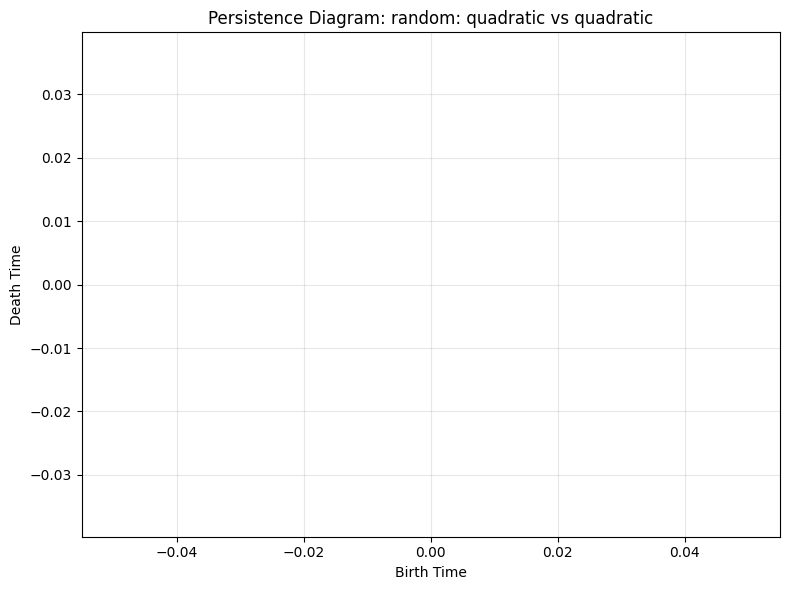


Comparing gaussian vs gaussian:


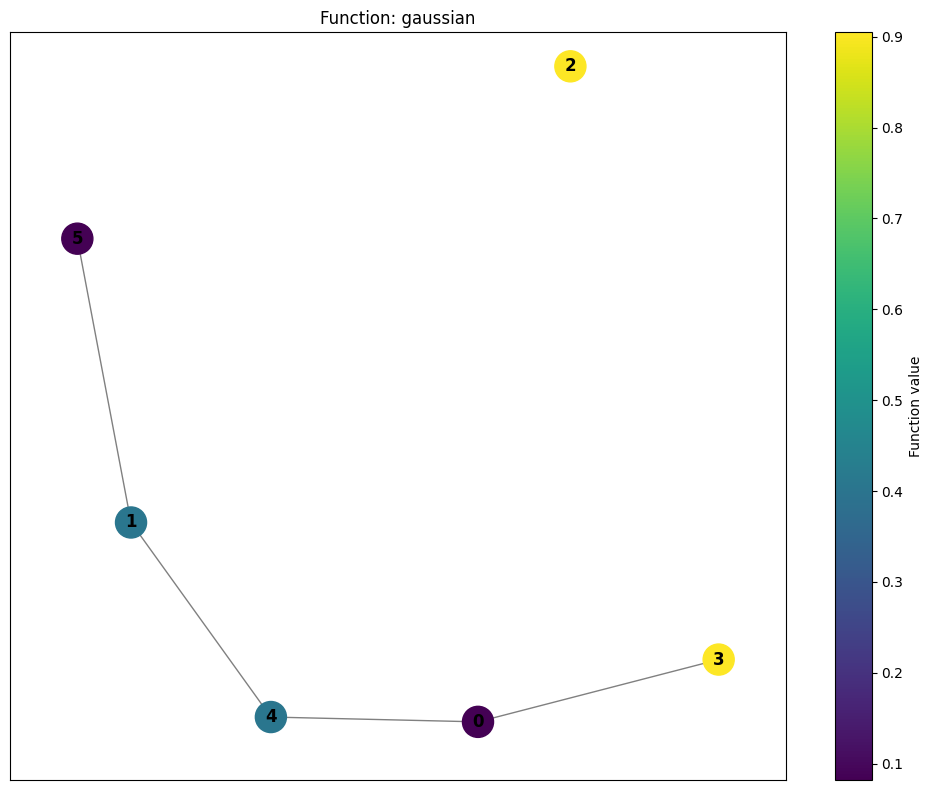

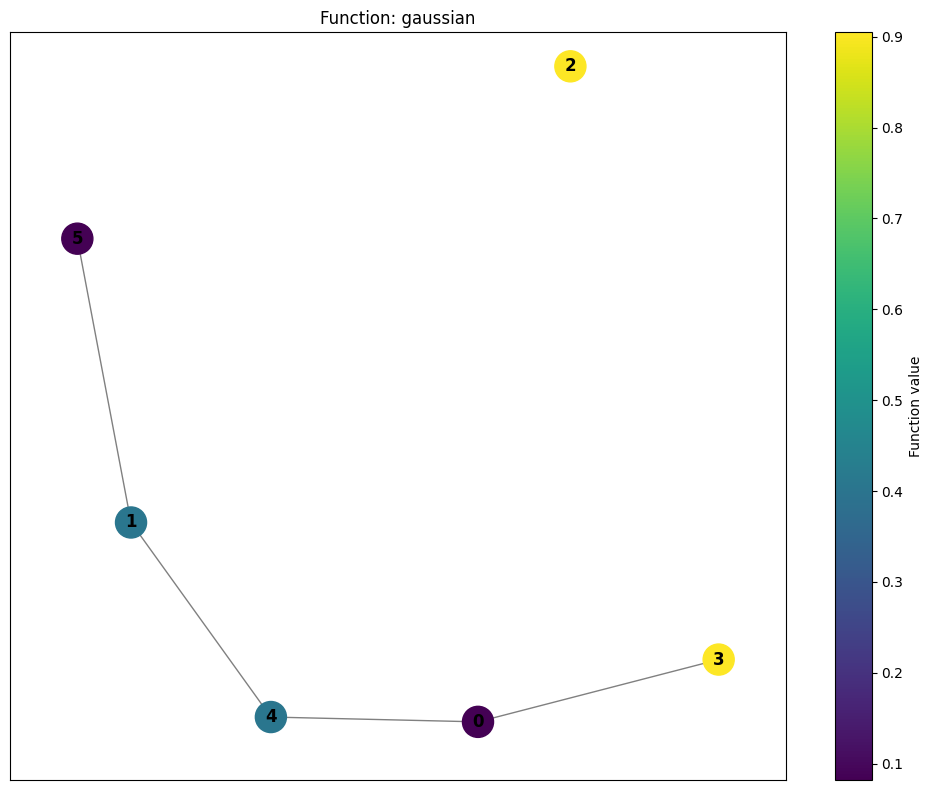

Persistence pairs (dimension 1):
  Birth: 0.905, Death: inf
  Birth: 0.407, Death: inf
  Birth: 0.407, Death: inf
  Birth: 0.407, Death: inf


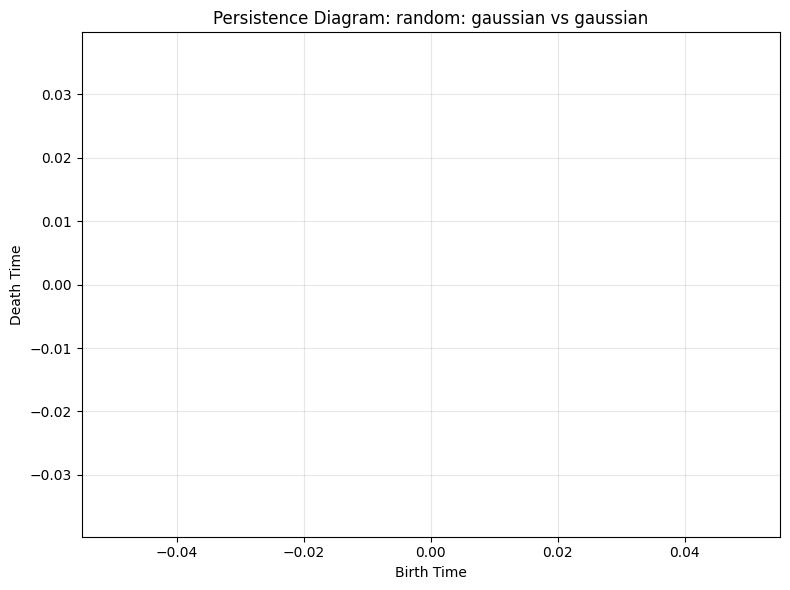


Comparing step vs step:


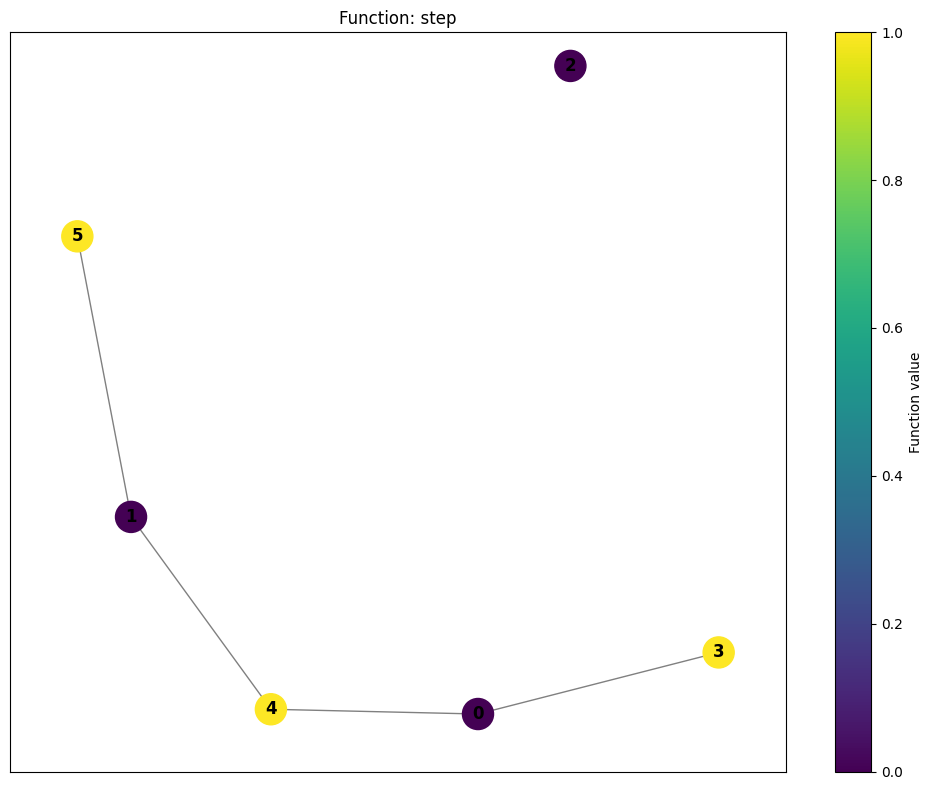

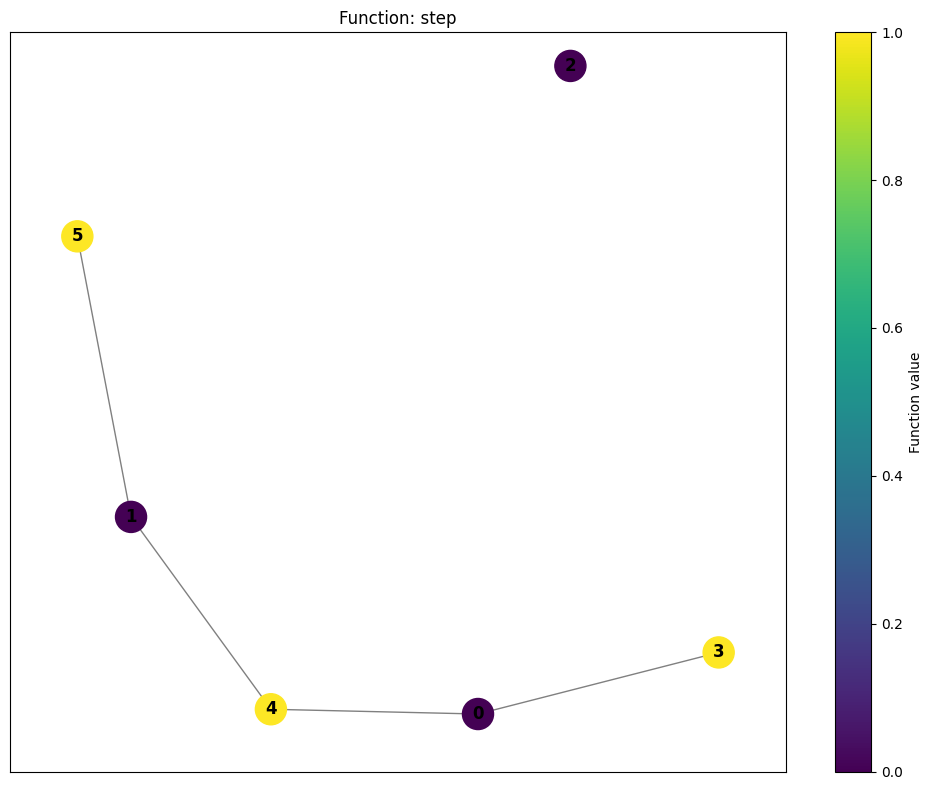

Persistence pairs (dimension 1):
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf
  Birth: 1.000, Death: inf


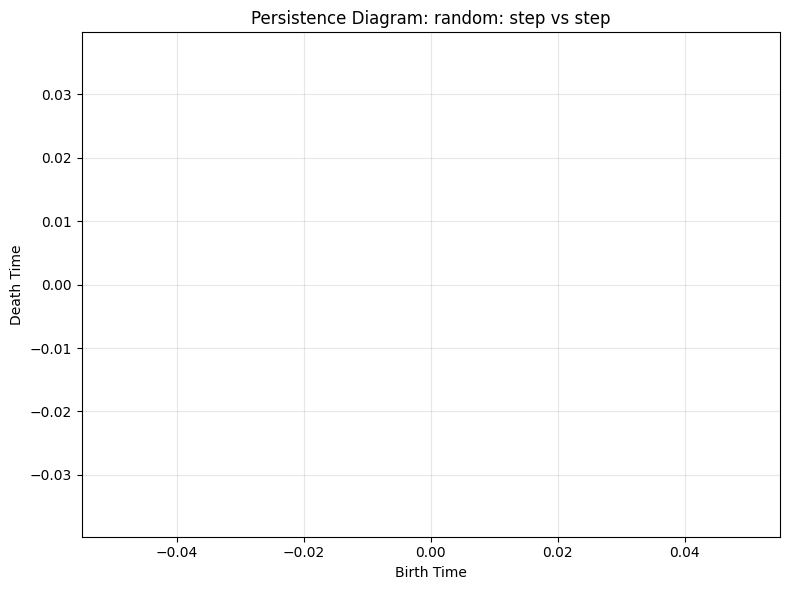

In [14]:
# Initialize TDA class
import logging


tda = TopologicalDivergence()

# Create graphs and functions
tda.create_graphs(n_vertices=6)

# Test for different graphs and functions
for graph_name, (graph, pos) in tda.graphs.items():
    n_vertices = len(graph.nodes())
    tda.create_functions(n_vertices)
    
    print(f"\n{'='*50}")
    print(f"Analyzing Graph: {graph_name.upper()}")
    print(f"{'='*50}")
    
    # Visualize the graph
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_weight='bold', edge_color='gray')
    plt.title(f"Graph: {graph_name}")
    plt.show()
    
    # Test all function combinations
    function_names = list(tda.functions.keys())
    
    for i, func1_name in enumerate(function_names):
        for j, func2_name in enumerate(function_names):
            if i <= j:  # Avoid duplicate pairs
                f = tda.functions[func1_name]
                g = tda.functions[func2_name]
                
                print(f"\nComparing {func1_name} vs {func2_name}:")
                
                # Visualize functions
                tda.visualize_graph_function(graph, pos, f, f"Function: {func1_name}")
                tda.visualize_graph_function(graph, pos, g, f"Function: {func2_name}")
                
                # Compute F-cross barcode for k=1 (1-dimensional homology)
                try:
                    persistence = tda.f_cross_barcode_k(graph, f, g, k=1)
                    
                    if persistence:
                        print(f"Persistence pairs (dimension 1):")
                        for dim, (birth, death) in persistence:
                            print(f"  Birth: {birth:.3f}, Death: {death:.3f}")
                        
                        # Visualize persistence diagram
                        tda.visualize_persistence_diagram(persistence, 
                                                        f"{graph_name}: {func1_name} vs {func2_name}")
                    else:
                        print("No persistence pairs found for dimension 1")
                    break 
                        
                except Exception as e:
                    import traceback 
                    logging.traceback()
                    print(f"Error computing persistence: {e}")
                    break 